In [1]:
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data
import config
import network

In [2]:
scan_100307 = process_data.get_nifti_data(config.data_folder2 + '/100307/data.nii.gz')
mask_100307 = process_data.get_nifti_data(config.data_folder2 + '/100307/nodif_brain_mask.nii.gz')
mask_100307_long_pro = process_data.get_mask_pro(scan_100307, mask_100307)

In [3]:
normalized_scan_100307_full = np.load(config.norm_data_path + '/normalized_scan_100307_full.npy')
# normalized_scan_100307_full = np.load('normalized_scan_100610_full.npy')

In [4]:
bvals_all_100307 = np.loadtxt(config.data_folder2 + '/100307/bvals')

In [6]:
selected_indice = [ 0, 1, 2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  64,  65,  66,  67,  68,  69,  70,
        71,  72,  73,  74,  75,  76,  77,  78,  79, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 176,
       177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189,
       190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202,
       203, 204, 205, 206, 207, 272, 273, 274, 275, 276, 277, 278, 279,
       280, 281, 282, 283, 284, 285, 286, 287]

In [7]:
bvals_100307_selected = bvals_all_100307[selected_indice]*1e-3

In [8]:
normalized_scan_100307_sub = normalized_scan_100307_full[:,selected_indice]

In [9]:
big_b_bvals_100307_selected = np.where(bvals_100307_selected != 0.005)[0]

In [10]:
normalized_scan_100307_sub_no_b5 = normalized_scan_100307_sub[:, big_b_bvals_100307_selected]
bvals_100307_selected_no_5 = bvals_100307_selected[big_b_bvals_100307_selected]

In [11]:
n_all_100307 = np.loadtxt(config.data_folder2 + '/100307/bvecs')
n_100307_sub = n_all_100307[:,selected_indice]
n_100307_sub_no_b5 = n_100307_sub[:,big_b_bvals_100307_selected].T
print(n_100307_sub_no_b5.shape)

b_values_100307_sub = torch.FloatTensor(bvals_100307_selected_no_5)
gradient_directions_100307_sub = torch.FloatTensor(n_100307_sub_no_b5)

(105, 3)


In [12]:
net = network.BallStickNet(gradient_directions_100307_sub, b_values_100307_sub)
net.load_state_dict(torch.load("/Users/weiwenhua/UGY4/COMP0029/COMP0029-Project/deep-BAS-subsets/Models/model_100206_7g_03_retrain_trainset.pt"))
net.eval()


# net = network.BallStickNet(len(b_values_100307_sub))
# net.load_state_dict(torch.load("/Users/weiwenhua/UGY4/COMP0029/COMP0029-Project/deep-BAS-subsets/Models/model_100206_13g_01_retrain.pt"))
# net.eval()

BallStickNet(
  (fc_layers): ModuleList(
    (0): Linear(in_features=105, out_features=105, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=105, out_features=105, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=105, out_features=105, bias=True)
    (5): ELU(alpha=1.0)
  )
  (encoder): Sequential(
    (0): Linear(in_features=105, out_features=105, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=105, out_features=105, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=105, out_features=105, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=105, out_features=5, bias=True)
  )
)

In [13]:
with torch.no_grad():
    X_100307_pred, theta_100307_pred, phi_100307_pred, mu_cart_100307_pred, lambda_par_100307_pred, lambda_iso_100307_pred,  volume_0_100307_pred, volume_1_100307_pred = net(torch.from_numpy(normalized_scan_100307_sub_no_b5.astype(np.float32)))

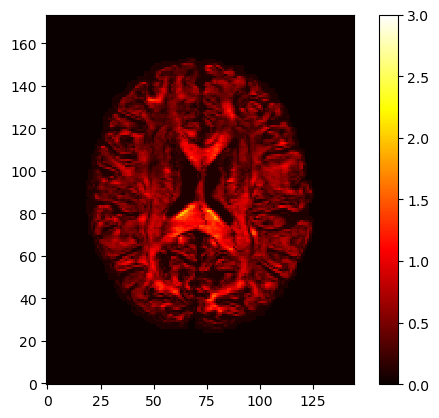

In [14]:
lambda_par_100307_pred_3d = process_data.back_to_3D(mask_100307_long_pro, lambda_par_100307_pred, (145, 174, 145))
im = plt.imshow(lambda_par_100307_pred_3d[:,:,70].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"], vmin = 0, vmax = 3)
plt.colorbar(im)

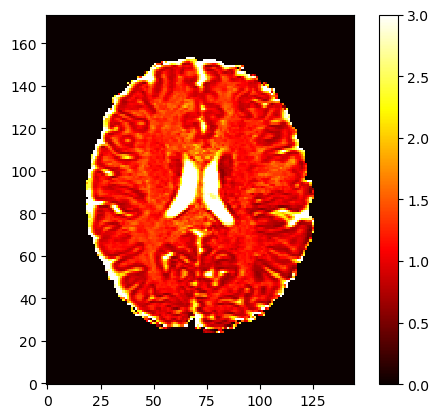

In [15]:
lambda_iso_100307_pred_3d = process_data.back_to_3D(mask_100307_long_pro, lambda_iso_100307_pred, (145, 174, 145))
im = plt.imshow(lambda_iso_100307_pred_3d[:,:,70].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"], vmin = 0, vmax = 3)
plt.colorbar(im)

Golden standard

In [16]:
big_b_indices_100307 = np.where(bvals_all_100307 != 5.)[0]

In [17]:
bvals_100307_no_b5 = bvals_all_100307[big_b_indices_100307]*1e-3

In [18]:
normalized_scan_100307_no_b5 = normalized_scan_100307_full[:, big_b_indices_100307]

In [19]:
n_100307_no_b5 = n_all_100307[:,big_b_indices_100307].T

In [20]:
b_values_100307 = torch.FloatTensor(bvals_100307_no_b5)
gradient_directions_100307 = torch.FloatTensor(n_100307_no_b5)

In [21]:
# net_golden_std = network.BallStickNet(gradient_directions_100307, b_values_100307)
# net_golden_std.load_state_dict(torch.load("/Users/weiwenhua/UGY4/COMP0029/COMP0029-Project/deep-ball-stick/model_100206_norm_01_Feb_182e.pt"))
# net_golden_std.eval()

# net_golden_std = network.BallStickNet(len(b_values_100307))
# net_golden_std.load_state_dict(torch.load("/Users/weiwenhua/UGY4/COMP0029/COMP0029-Project/deep-ball-stick/model_100206_norm_01_Feb_182e.pt"))
# net_golden_std.eval()

net_golden_std = network.BallStickNet(gradient_directions_100307, b_values_100307)
net_golden_std.load_state_dict(torch.load("/Users/weiwenhua/UGY4/COMP0029/COMP0029-Project/deep-BAS-subsets/Models/model_100206_golden_std_retrain_trainset.pt"))
net_golden_std.eval()

BallStickNet(
  (fc_layers): ModuleList(
    (0): Linear(in_features=270, out_features=270, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=270, out_features=270, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=270, out_features=270, bias=True)
    (5): ELU(alpha=1.0)
  )
  (encoder): Sequential(
    (0): Linear(in_features=270, out_features=270, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=270, out_features=270, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=270, out_features=270, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=270, out_features=5, bias=True)
  )
)

In [22]:
with torch.no_grad():
    X_100307_pred_gstd,theta_100307_pred_gstd, phi_100307_pred_gstd, mu_cart_100307_pred_gstd, lambda_par_100307_pred_gstd, lambda_iso_100307_pred_gstd, volume_0_100307_pred_gstd, volume_1_100307_pred_gstd = net_golden_std(torch.from_numpy(normalized_scan_100307_no_b5.astype(np.float32)))

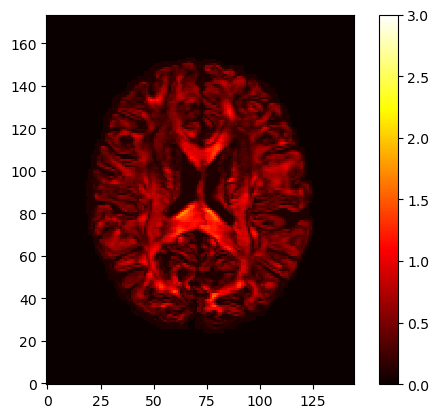

In [23]:
lambda_par_100307_pred_gstd_3d = process_data.back_to_3D(mask_100307_long_pro, lambda_par_100307_pred_gstd, (145, 174, 145))
im = plt.imshow(lambda_par_100307_pred_gstd_3d[:,:,70].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"], vmin = 0, vmax = 3)
plt.colorbar(im)

In [23]:
mu_cart_100307_pred_gstd

tensor([[ 0.1888,  0.5349,  0.6016,  ...,  0.5509, -0.5324, -0.4095],
        [ 0.9579,  0.4682,  0.4306,  ...,  0.8208,  0.6866,  0.8606],
        [ 0.2162, -0.7034, -0.6728,  ...,  0.1508, -0.4952, -0.3029]],
       grad_fn=<CopySlices>)

In [24]:
mu_cart_100307_pred

tensor([[ 0.2312,  0.5892,  0.6408,  ...,  0.6622, -0.4965, -0.2689],
        [ 0.9655,  0.5044,  0.3519,  ...,  0.7448,  0.7196,  0.8891],
        [ 0.1197, -0.6312, -0.6822,  ...,  0.0828, -0.4854, -0.3703]],
       grad_fn=<CopySlices>)

In [66]:
n_all_100307

array([[ 0.519218,  0.940461,  0.33274 ,  0.062696,  0.195299,  0.469331,
         0.702082,  0.277576, -0.636052,  0.882737,  0.224295,  0.201882,
         0.843525, -0.448841,  0.972035,  0.273082, -0.517173,  0.874913,
        -0.462356, -0.041258, -0.785634,  0.527427, -0.197852,  0.790547,
        -0.364541,  0.65342 , -0.494403,  0.753075, -0.312991,  0.443738,
        -0.892087,  0.533812, -0.517056, -0.248187, -0.610885,  0.610531,
        -0.176929,  0.202136, -0.873268,  0.883453, -0.337405, -0.047389,
         0.542681,  0.858772,  0.188905,  0.021357,  0.812345,  0.999012,
         0.518146,  0.016815,  0.939281,  0.10938 ,  0.615123,  0.079717,
         0.21232 ,  0.624695,  0.500341,  0.445286,  0.686432,  0.719825,
        -0.065414,  0.565775,  0.540141,  0.722051,  0.518917,  0.184341,
         0.56399 ,  0.694944,  0.991421,  0.115499,  0.842074,  0.259957,
         0.436452,  0.892304,  0.568993,  0.772571, -0.220232,  0.587616,
         0.18296 ,  0.323551,  0.52049

Mean square error

In [24]:
mse = torch.nn.MSELoss(reduction='mean')

In [25]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0051)
tensor(0.0115)
tensor(0.0002)
tensor(0.0002)


In [32]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0034)
tensor(0.0041)
tensor(0.0002)
tensor(0.0002)


In [34]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0037)
tensor(0.0045)
tensor(0.0002)
tensor(0.0002)


cosine similarity

In [29]:
cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)
output = cos(mu_cart_100307_pred_gstd, mu_cart_100307_pred)
print(output)

tensor([0.8710, 0.9743, 0.9650,  ..., 0.9991, 0.7693, 0.9251],
       grad_fn=<SumBackward1>)


(array([ 11270.,   3135.,   2869.,   3171.,   3669.,   4766.,   7141.,
         13617.,  39011., 651496.]),
 array([-9.99986708e-01, -7.99988031e-01, -5.99989355e-01, -3.99990708e-01,
        -1.99992031e-01,  6.64591789e-06,  2.00005323e-01,  4.00003999e-01,
         6.00002646e-01,  8.00001323e-01,  1.00000000e+00]),
 <BarContainer object of 10 artists>)

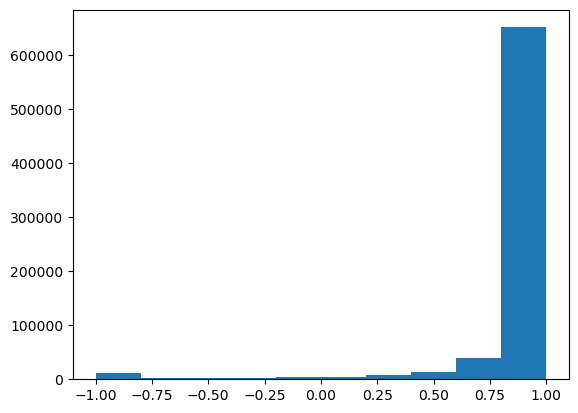

In [30]:
plt.hist(output.detach().numpy())

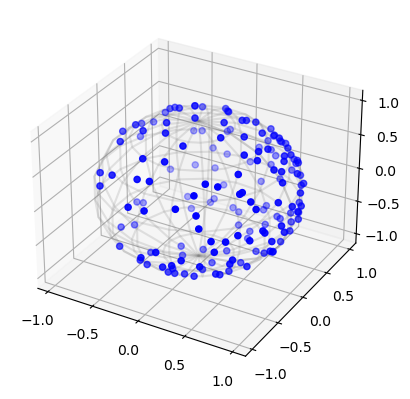

In [26]:

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the normalized gradient directions
ax.scatter(n_100307_sub_no_b5[:, 0], n_100307_sub_no_b5[:, 1], n_100307_sub_no_b5[:, 2], c='b', marker='o')
# ax.scatter(-n_100307_sub_no_b5[:, 0], -n_100307_sub_no_b5[:, 1], -n_100307_sub_no_b5[:, 2], c='b', marker='o')

# # Set limits of the plot to fit the sphere
# ax.set_xlim([-1, 1])
# ax.set_ylim([-1, 1])
# ax.set_zlim([-1, 1])

# # Set equal aspect ratio for all three axes
# ax.set_box_aspect([1, 1, 1])

# Add a sphere to the plot
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)
ax.plot_wireframe(x, y, z, color='gray', alpha=0.2)

# # Show the plot
# plt.show()
# plot 
# Check the 

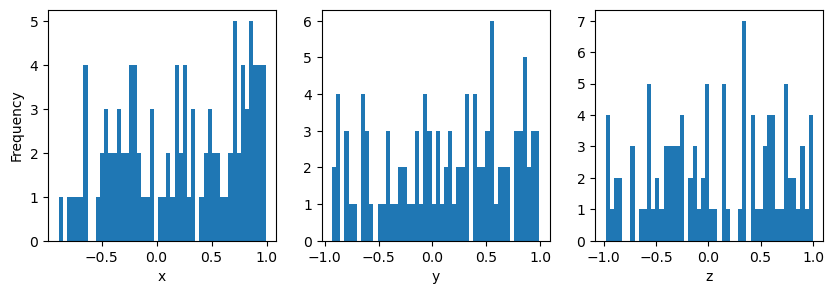

In [26]:
# Create histograms of the gradient directions along each axis
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs[0].hist(n_100307_sub_no_b5[:, 0], bins=50)
axs[0].set_xlabel('x')
axs[0].set_ylabel('Frequency')
axs[1].hist(n_100307_sub_no_b5[:, 1], bins=50)
axs[1].set_xlabel('y')
axs[2].hist(n_100307_sub_no_b5[:, 2], bins=50)
axs[2].set_xlabel('z')
plt.show()

In [27]:
dot_product = 1/91 * np.dot (n_100307_sub_no_b5.T, n_100307_sub_no_b5)

In [28]:
dot_product

array([[0.57721836, 0.00477519, 0.00484623],
       [0.00477519, 0.60665553, 0.00524032],
       [0.00484623, 0.00524032, 0.64030138]])

In [91]:
dot_product_2nd_moment = np.mean(np.square(dot_product_all))
print(dot_product_2nd_moment)

0.3333472526322432


In [ ]:
tensor(0.0051)
tensor(0.0115)
tensor(0.0002)
tensor(0.0002)

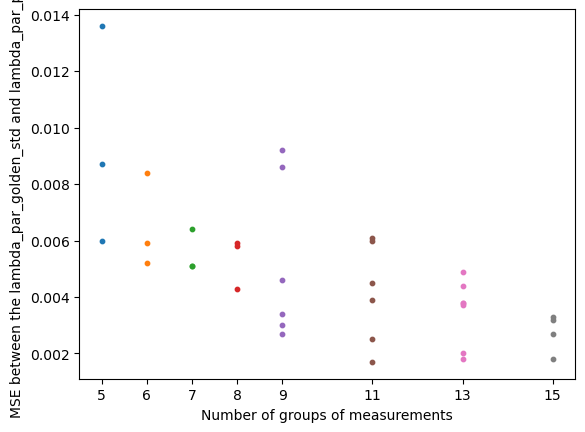

In [35]:
x_values = [5, 6, 7, 8, 9, 11, 13, 15]
y_values = [[0.0060, 0.0136,0.0087], [0.0059,0.0052,0.0084], [0.0051, 0.0051, 0.0064], [0.0059, 0.0043, 0.0058], [0.0030, 0.0046, 0.0034, 0.0027, 0.0092, 0.0086],[0.0017, 0.0045,0.0061,0.0060,0.0039,0.0025], [0.0049,0.0037,0.0038,0.0038,0.0044,0.0020,0.0018],[0.0032,0.0033,0.0018,0.0027]]

fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i], s=10)
    
ax.set_xlabel('Number of groups of measurements')
ax.set_ylabel('MSE between the lambda_par_golden_std and lambda_par_pred')

ax.set_xticks(x_values)

# best pred using 9 gropus of measurements
# -> b values /  * gradient direction arr in shape of (3, 288)
#                 scoring 统计差不多的方向（a,b,c）的数量，展现方向的distribution (histgram)
    
# mean((pred-mean(ground_truth))^2)
# avg_acc variance 
# simulated signals

# 蒙特卡洛采样


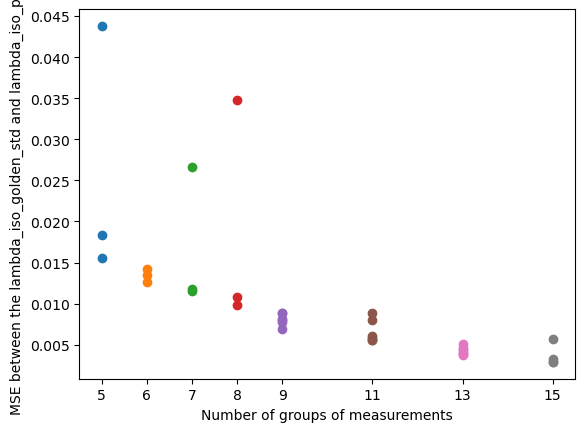

In [28]:
# x_values = [1, 5, 6, 7, 8, 9]
# y_values = [[0.0783], [0.0184], [0.0142], [0.0118, 0.0110], [0.0348, 0.0108], [0.0089, 0.0088, 0.0080, 0.0069, 0.0077, 0.0081]]
x_values = [5, 6, 7, 8, 9,11, 13,15]
y_values = [[0.0184, 0.0438,0.0155], [0.0142,0.0135,0.0126], [0.0118, 0.0115, 0.0266], [0.0348, 0.0108, 0.0098], [0.0089, 0.0088, 0.0080, 0.0069, 0.0077, 0.0081], [0.0058, 0.0056,0.0060,0.0088,0.0080,0.0056], [0.0042, 0.0045, 0.0046,0.0051,0.0039,0.0040,0.0038],[0.0029,0.0057,0.0032,0.0029]]

fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i])
    
ax.set_xlabel('Number of groups of measurements')
ax.set_ylabel('MSE between the lambda_iso_golden_std and lambda_iso_pred')

ax.set_xticks(x_values)

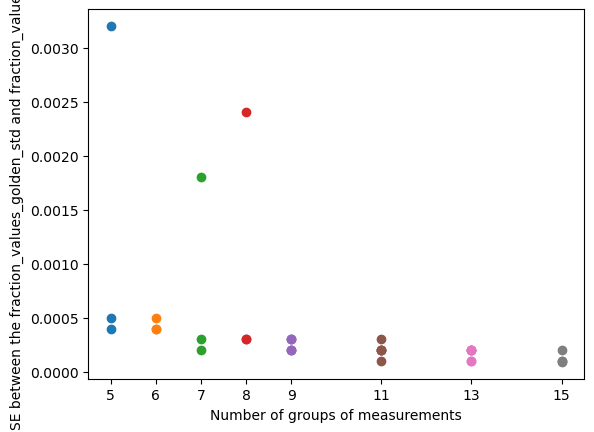

In [29]:
# x_values = [1, 5, 6, 7, 8, 9]
# y_values = [[0.0029], [0.0004], [0.0004], [0.0003, 0.0004], [0.0024, 0.0003], [0.0002, 0.0003, 0.0002, 0.0002, 0.0003, 0.0003]]
x_values = [5, 6, 7, 8, 9, 11, 13, 15]
y_values = [[0.0004,0.0032,0.0005], [0.0004,0.0004,0.0005], [0.0003, 0.0002, 0.0018], [0.0024, 0.0003, 0.0003], [0.0002, 0.0003, 0.0002, 0.0002, 0.0003, 0.0003],[0.0001, 0.0002,0.0003,0.0002,0.0002,0.0002], [0.0002, 0.0002, 0.0002,0.0002,0.0002,0.0001,9.9272e-05],[0.0001,0.0001,9.1013e-05,0.0002]]

fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i])
    
ax.set_xlabel('Number of groups of measurements')
ax.set_ylabel('MSE between the fraction_values_golden_std and fraction_values_pred')

ax.set_xticks(x_values)

In [ ]:
# mean((p - mean(gtd))^2) 

In [112]:
rand_sub_bval_indice_100307 = np.array(process_data.get_rand_selected_bval_indice(bvals_all_100307, 9))

In [111]:
np.unique(bvals_all_100307[rand_sub_bval_indice_100307])

array([   5.,  990.,  995., 1000., 1005., 1985., 1990., 1995., 2000.,
       2005., 2010., 2980., 2985., 2990., 2994., 2995., 3000., 3005.,
       3010.])

In [113]:
np.unique(bvals_all_100307[rand_sub_bval_indice_100307])

array([   5.,  990.,  995., 1000., 1005., 1985., 1990., 1995., 2000.,
       2005., 2010., 2980., 2985., 2990., 2995., 3000., 3005., 3010.])

In [ ]:
# Training data 1000 2000 3000

# Testing data 3000 2000 1000